<a href="https://colab.research.google.com/github/dayoxy/Generative-Adversarial-Networks/blob/main/Copy_of_dayo_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN's using pyTorch.



Automatically downloading the MNIST dataset to my specified directory.




Generator and Discriminator models, training, visualization and comparision.


In [ ]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
pip install torchvision matplotlib numpy

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import numpy as np
import torch.optim as optim

from torchvision import datasets, transforms, utils

Hyperparameters and training

In [ ]:
latent_dim = 100        # Dimension of latent
batch_size = 128         # Batch size during training
feature_map_size = 28         #feature map size
num_epochs = 200        # Number of training epochs
learning_rate = 0.0002  # Optimizer learning rate
beta1 = 0.5             # hyperparameter for Adam
beta2 = 0.999           # hyperparameter for Adam

In [ ]:
#Checking for GPU and modifying
print("CUDA Available:", torch.cuda.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA Available: True
GPU Device Name: Tesla T4
Using device: cuda:0


Loading Dataset

In [ ]:
#Defining the transformation pipeline to ensure proper scaling for images
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))     #Normalizing the images
])

In [ ]:
data_path = r"C:\Users\HP\OneDrive\Documents\GAN's Project\data\raw"
dataset = datasets.MNIST(root=data_path, train=True, transform=transform, download=True)
#MNIST dataset automatically downloaded from Yann LeCun website to my specified directory

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.86MB/s]


Extracting C:\Users\HP\OneDrive\Documents\GAN's Project\data\raw/MNIST/raw/train-images-idx3-ubyte.gz to C:\Users\HP\OneDrive\Documents\GAN's Project\data\raw/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 66.1kB/s]


Extracting C:\Users\HP\OneDrive\Documents\GAN's Project\data\raw/MNIST/raw/train-labels-idx1-ubyte.gz to C:\Users\HP\OneDrive\Documents\GAN's Project\data\raw/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 245kB/s]


Extracting C:\Users\HP\OneDrive\Documents\GAN's Project\data\raw/MNIST/raw/t10k-images-idx3-ubyte.gz to C:\Users\HP\OneDrive\Documents\GAN's Project\data\raw/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.70MB/s]

Extracting C:\Users\HP\OneDrive\Documents\GAN's Project\data\raw/MNIST/raw/t10k-labels-idx1-ubyte.gz to C:\Users\HP\OneDrive\Documents\GAN's Project\data\raw/MNIST/raw



In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
#using torchvision MNIST datatset loader.


In [ ]:
# os.makedirs("generated_images")

#created folder to save generated images from the generator
output_dir = "generated_images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
def show_images(tensor, title=None):
    grid = utils.make_grid(tensor, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

GAN's Architecture

In [ ]:
# Generator Model: Generates fake images
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Output value using Tanh
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.main(z)

In [ ]:
noise = torch.randn(batch_size, latent_dim, device=device)

In [ ]:
#Discriminator Model: Distinguishes between the real and generated images.

class Discriminator(nn.Module):
    def __init__ (self, img_channels=1, feature_map_size=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(img_channels, feature_map_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size, feature_map_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size * 4, 1, kernel_size=5, stride=1, padding=0, bias=False),
            nn.Sigmoid()  #Output probablity.
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [ ]:
#Instantiate models and move to device
latent_dim = 100
netGen = Generator(latent_dim=latent_dim, img_channels=1).to(device)
netDis = Discriminator(img_channels=1, feature_map_size=64).to(device)


In [ ]:
# Binary Cross Entropy Loss Function and Adam Optimizer
criterion = nn.BCELoss()
optimizerGen = optim.Adam(netGen.parameters(), lr=learning_rate, betas=(beta1, beta2))
optimizerDis = optim.Adam(netDis.parameters(), lr=learning_rate, betas=(beta1, beta2))

In [ ]:
# Labelling for Real and Fake images
real_label = 1.0
fake_label = 0.0

In [ ]:
# Creating label tensors
real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)


In [ ]:
print("Starting GAN training...")

# Recording Generator and Discriminator Loss
Gen_losses = []
Dis_losses = []

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        b_size = real_images.size(0)
        real_images = real_images.to(device)
        # Creating label tensors using predefined values
        real_labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        fake_labels = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

        # Discriminator Training
        try:
            netDis.zero_grad()
            # Train with real images
            output_real = netDis(real_images).view(-1)
            lossD_real = criterion(output_real, real_labels)
            lossD_real.backward()

            # Train with fake images
            noise = torch.randn(b_size, latent_dim, device=device)
            fake_images = netGen(noise)
            output_fake = netDis(fake_images.detach()).view(-1)
            lossD_fake = criterion(output_fake, fake_labels)
            lossD_fake.backward()

            # Combined loss
            lossD = lossD_real + lossD_fake
            optimizerDis.step()

        except Exception as e:
            print(f"Error in discriminator training: {str(e)}")
            continue

        # Generator Training
        netGen.zero_grad()
        output = netDis(fake_images).view(-1)
        lossG = criterion(output, real_labels)
        lossG.backward()
        optimizerGen.step()

        # Recording Values of Loss for both Generator and Discriminator
        Gen_losses.append(lossG.item())
        Dis_losses.append(lossD.item())

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}/{len(dataloader)}] - Loss_D: {lossD.item():.4f}, Loss_G: {lossG.item():.4f}")

    # Saving images generated at the current epoch
    with torch.no_grad():
        fixed_noise = torch.randn(64, latent_dim, device=device)
        fake_imgs_epoch = netGen(fixed_noise).detach().cpu()
    grid = utils.make_grid(fake_imgs_epoch, nrow=8, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Generated Images - Epoch {epoch+1}")
    plt.axis("off")
    plt.savefig(f"generated_images/epoch_{epoch+1}.png")
    plt.close()

print("Training finished.")

Starting GAN training...
Epoch [1/200], Batch [0/469] - Loss_D: 1.5221, Loss_G: 0.9432
Epoch [1/200], Batch [100/469] - Loss_D: 0.5337, Loss_G: 1.4352
Epoch [1/200], Batch [200/469] - Loss_D: 0.7132, Loss_G: 2.2017
Epoch [1/200], Batch [300/469] - Loss_D: 0.4539, Loss_G: 2.3953
Epoch [1/200], Batch [400/469] - Loss_D: 0.2914, Loss_G: 2.9309
Epoch [2/200], Batch [0/469] - Loss_D: 0.4206, Loss_G: 2.1636
Epoch [2/200], Batch [100/469] - Loss_D: 0.2210, Loss_G: 2.8867
Epoch [2/200], Batch [200/469] - Loss_D: 0.2164, Loss_G: 2.5772
Epoch [2/200], Batch [300/469] - Loss_D: 0.2425, Loss_G: 2.9293
Epoch [2/200], Batch [400/469] - Loss_D: 0.2375, Loss_G: 3.3215
Epoch [3/200], Batch [0/469] - Loss_D: 0.2100, Loss_G: 3.0589
Epoch [3/200], Batch [100/469] - Loss_D: 0.6083, Loss_G: 2.9122
Epoch [3/200], Batch [200/469] - Loss_D: 0.3510, Loss_G: 2.2755
Epoch [3/200], Batch [300/469] - Loss_D: 0.2365, Loss_G: 2.5360
Epoch [3/200], Batch [400/469] - Loss_D: 0.8746, Loss_G: 2.3411
Epoch [4/200], Batch 

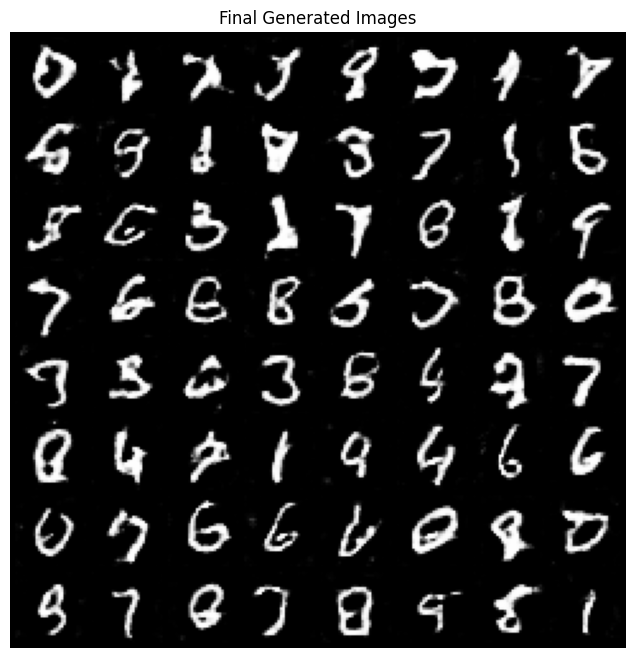

In [ ]:
## Final Generated Images
with torch.no_grad():
    final_noise = torch.randn(64, latent_dim, device=device)
    final_generated = netGen(final_noise).detach().cpu()
grid_generated = utils.make_grid(final_generated[:64], nrow=8, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid_generated, (1,2,0)))
plt.title("Final Generated Images")
plt.axis("off")
plt.show()

Model Performance Evaluation Plot Loss Curve

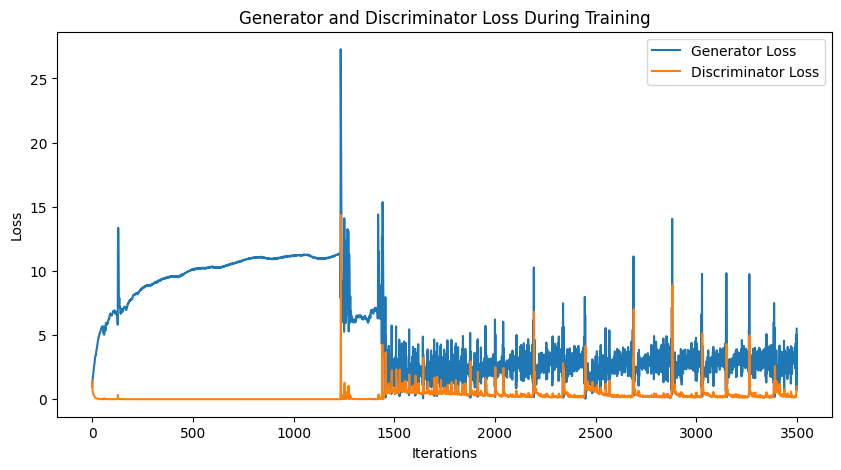

In [ ]:
# Plotting Generator and Discriminator Loss
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(Gen_losses, label="Generator Loss")
plt.plot(Dis_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Comparision Of Final Generated Images with Real Images

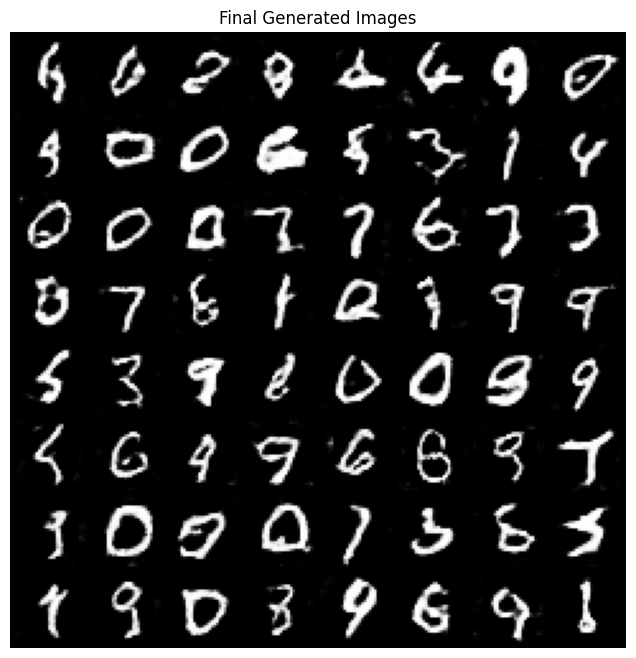

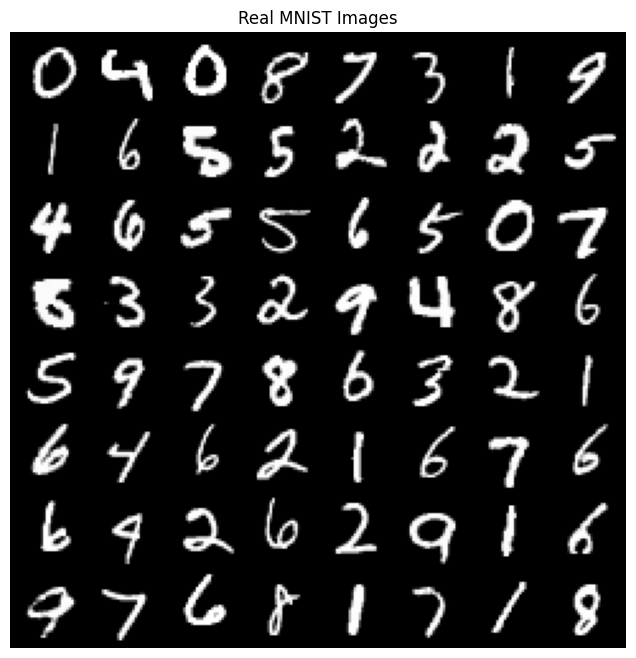

In [ ]:
# Show final generated images
with torch.no_grad():
    final_noise = torch.randn(64, latent_dim, device=device)
    final_generated = netGen(final_noise).detach().cpu()
show_images(final_generated[:64], "Final Generated Images")

# Show real images for comparison
real_samples, _ = next(iter(dataloader))
show_images(real_samples[:64], "Real MNIST Images")

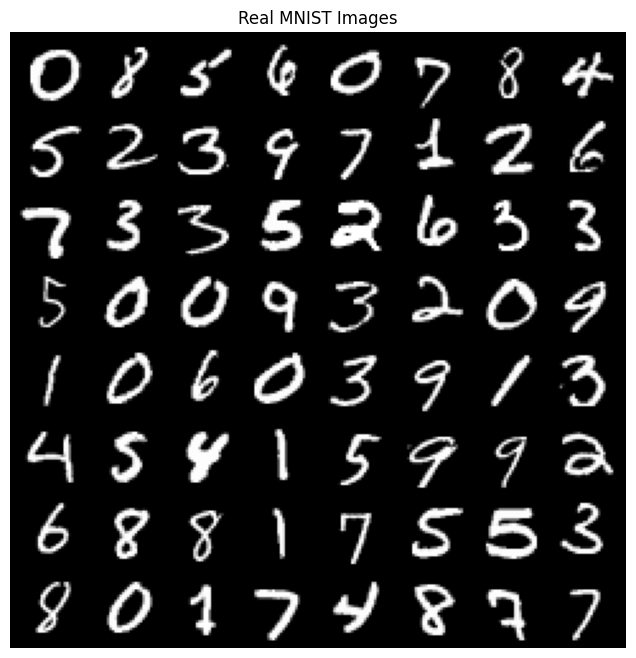

In [ ]:
# Batch of real images for comparisions

real_samples, _ = next(iter(dataloader))
grid_real = utils.make_grid(real_samples[:64], nrow=8, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid_real, (1,2,0)))
plt.title("Real MNIST Images")
plt.axis("off")
plt.show()

In [ ]:
# Save Generator Model
save_path = "C:/Users/HP/OneDrive/Documents/GAN's Project/model/model.pth"
# Create parent directory if it does not exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(netGen.state_dict(), save_path)
print(f"Generator model saved to {save_path}")

Generator model saved to C:/Users/HP/OneDrive/Documents/GAN's Project/model/model.pth
